In [1]:
import pandas as pd
from src.modelado import categorizar_horas
from src.modelado import dividir_datos
from src.modelado import pipeline_preprocesamiento
from src.modelado import entrenar_modelo
from src.modelado import calcular_matriz_confusion
from src.modelado import graficar_matriz_confusion
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import pickle


In [2]:
df = pd.read_csv("../data/tattoo_studio_clean.csv")

In [3]:
df["Session_Hours_Cat"] = df["Session_Hours"].apply(categorizar_horas)

In [4]:
y = df["Session_Hours_Cat"]
X = df.drop(columns=["Session_Hours", "Session_Hours_Cat"])

In [5]:
X_train, X_test, y_train, y_test = dividir_datos(X, y)

In [6]:
preprocesamiento = pipeline_preprocesamiento(X)

In [7]:
modelo = entrenar_modelo(preprocesamiento, X_train, y_train)

In [8]:
y_pred = modelo.predict(X_test)
cm = calcular_matriz_confusion(y_test, y_pred)
cm

array([[230,  17,   0],
       [ 37,  78,   6],
       [  0,   1,  31]])

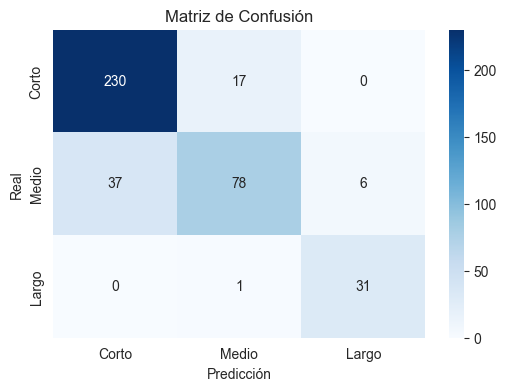

In [9]:
graficar_matriz_confusion(cm)


In [10]:
horas_reales = df.loc[X_test.index, "Session_Hours"]

In [11]:
rango_categorias = {
    "Corto": "0–3 horas",
    "Medio": "3–6 horas",
    "Largo": "6+ horas"
}
comparacion = pd.DataFrame({
    "Horas_Reales": horas_reales.values,
    "Predicción_Categoría": y_pred
})
comparacion["Rango_Predicción"] = comparacion["Predicción_Categoría"].map(rango_categorias)
comparacion.head()

,Horas_Reales,Predicción_Categoría,Rango_Predicción
0,1,Corto,0–3 horas
1,3,Corto,0–3 horas
2,3,Corto,0–3 horas
3,2,Corto,0–3 horas
4,2,Corto,0–3 horas


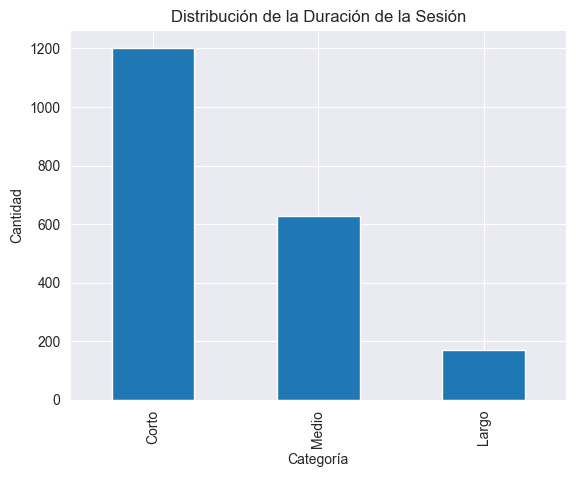

In [12]:
df["Session_Hours_Cat"].value_counts().plot(kind="bar")
plt.title("Distribución de la Duración de la Sesión")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.show()

In [13]:
df_clean = df.copy()
df_clean["Predicted_Session"] = modelo.predict(X)

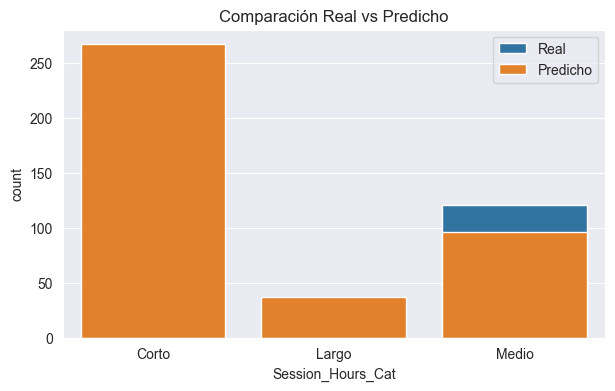

In [14]:
plt.figure(figsize=(7,4))
sns.countplot(x=y_test, label="Real")
sns.countplot(x=y_pred, label="Predicho")
plt.title("Comparación Real vs Predicho")
plt.legend(["Real", "Predicho"])
plt.show()


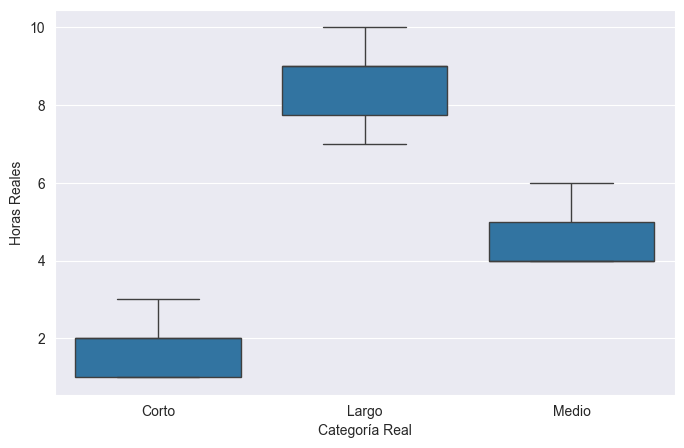

In [15]:
comparacion["Real_categ"] = comparacion["Horas_Reales"].apply(categorizar_horas)
comparacion["Predicho_categ"] = comparacion["Predicción_Categoría"]
comparacion.head()
plt.figure(figsize=(8,5))
sns.boxplot(x=comparacion["Real_categ"], y=comparacion["Horas_Reales"])
plt.xlabel("Categoría Real")
plt.ylabel("Horas Reales")
plt.show()


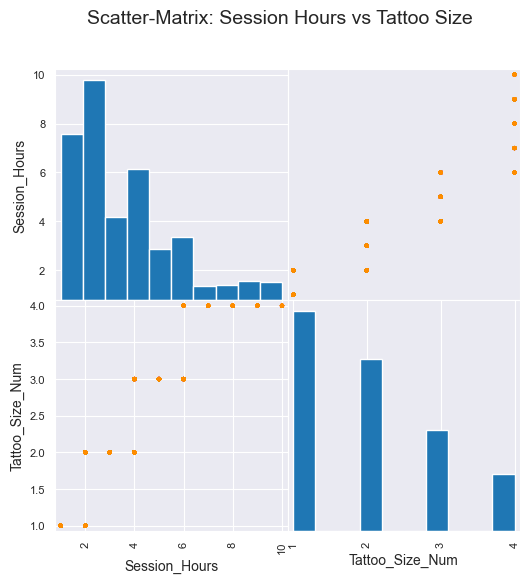

In [16]:
size_map = {
    "Small": 1,
    "Medium": 2,
    "Large": 3,
    "Sleeve/Back": 4
}
df["Tattoo_Size_Num"] = df["Tattoo_Size"].map(size_map)
vars_to_plot = ["Session_Hours", "Tattoo_Size_Num"]
scatter_matrix(df[vars_to_plot],
               figsize=(6, 6),
               diagonal='hist',
               alpha=0.7,
               color='darkorange')

plt.suptitle("Scatter-Matrix: Session Hours vs Tattoo Size", fontsize=14)
plt.show()

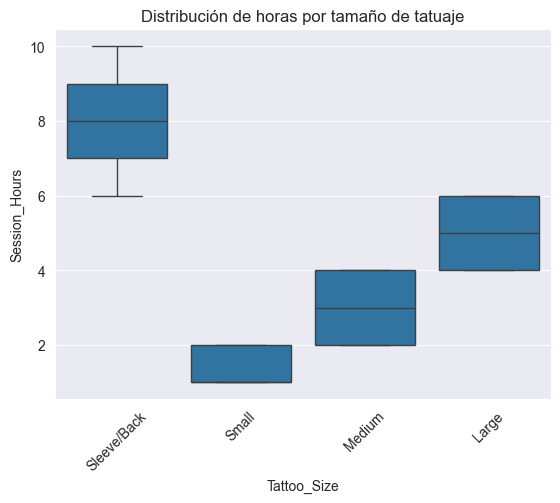

In [17]:
sns.boxplot(x="Tattoo_Size", y="Session_Hours", data=df)
plt.title("Distribución de horas por tamaño de tatuaje")
plt.xticks(rotation=45)
plt.show()

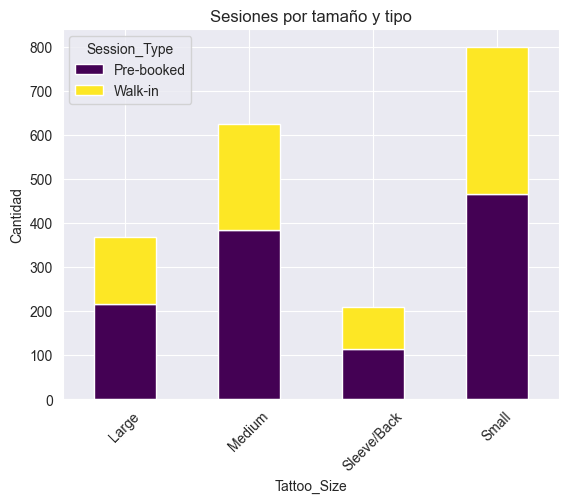

In [18]:
pd.crosstab(df["Tattoo_Size"], df["Session_Type"]).plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Sesiones por tamaño y tipo")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.show()



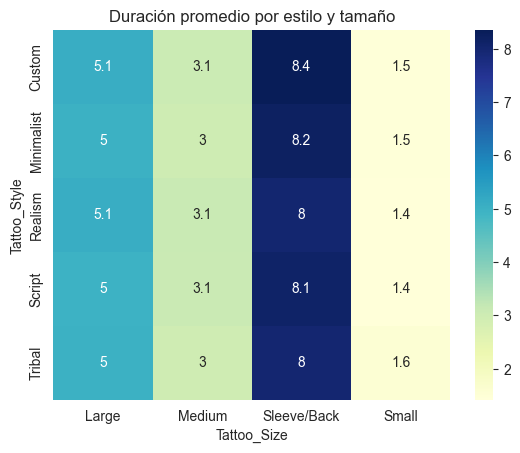

In [19]:
pivot = df.pivot_table(values="Session_Hours", index="Tattoo_Style", columns="Tattoo_Size", aggfunc="mean")
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Duración promedio por estilo y tamaño")
plt.show()


<Axes: xlabel='Tattoo_Style', ylabel='Session_Hours'>

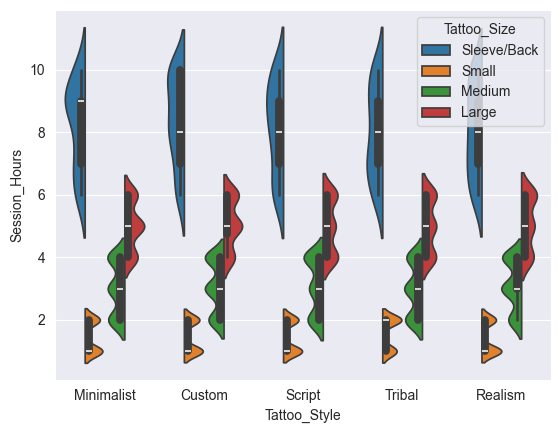

In [20]:
sns.violinplot(x="Tattoo_Style", y="Session_Hours", hue="Tattoo_Size", data=df, split=True)


In [21]:
with open("../data/modelo.pkl", "wb") as f:
    pickle.dump(modelo, f)